## Setup

In [6]:
from openai import OpenAI
import json
import csv
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the OpenAI client locally
# client = OpenAI(base_url="http://172.30.80.1:7878/v1", api_key="")

# Initialize the OpenAI client
client = OpenAI(api_key='')

/tmp/ipykernel_1142/3808366266.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Get company name

In [2]:
df = pd.read_csv('/mnt/c/Users/alotf/OneDrive - University of Surrey/[1] Raw Data/slr_paper/companies-2023.csv')
unique_types = df['industry'].value_counts().sort_values(ascending=False)

In [3]:
unique_types

industry
construction                         683107
it services and it consulting        651987
advertising services                 617887
business consulting and services     508608
real estate                          471242
                                      ...  
otelcilik                                 1
ict-services en consultancy               1
fabrication de véhicules à moteur         1
servicios de instalaciones                1
transporte terrestre en camión            1
Name: count, Length: 542, dtype: int64

In [4]:
unique_types.to_csv('unique_types.csv')

In [ ]:
prompt_placeholder = """
{story}
** Objective: Extract the company name and it's industry from this customer testimonial about a Business Intelligence tool. If it's not in the list, write 'other'. **

The industry you are looking for is one of the following: ['construction', 'it services and it consulting', 'advertising services',
       'business consulting and services', 'real estate', 'retail',
       'software development', 'financial services',
       'hospitals and health care', 'technology, information and internet',
       'wellness and fitness services', 'hospitality',
       'non-profit organizations', 'professional training and coaching',
       'medical practices', 'restaurants', 'information technology & services',
       'education administration programs', 'architecture and planning',
       'accounting', 'design services',
       'appliances, electrical, and electronics manufacturing',
       'food and beverage services', 'events services',
       'motor vehicle manufacturing', 'consumer services',
       'staffing and recruiting', 'legal services', 'media production',
       'individual and family services', 'civic and social organizations',
       'law practice', 'machinery manufacturing', 'spectator sports',
       'insurance', 'higher education', 'retail apparel and fashion',
       'industrial machinery manufacturing', 'wholesale',
       'entertainment providers', 'telecommunications', 'travel arrangements',
       'human resources services', 'environmental services', 'manufacturing',
       'oil and gas', 'transportation, logistics, supply chain and storage',
       'food and beverage manufacturing', 'facilities services',
       'truck transportation']

** Output: The company name and it's industry. For industry write the top three guesses. **
The output format should be in JSON format.
"""

In [3]:
def collect_data(stories, prompt_placeholder, client):
        """Collects data from the LLM model, storing results in an intermediate format.

        Args:
            stories: A list of stories (each as a dictionary with a 'content' key).
            prompt_placeholder: The prompt template with a '{story}' placeholder.
            client: The client object for interacting with the LLM.

        Returns:
            A list of results where each result is a dictionary.
        """

        results = []
        with tqdm.tqdm(total=len(stories), desc="Extracting") as pbar:
            for i, story in enumerate(stories):
                content = story['content']
                story_id = story['id']
                prompt = prompt_placeholder.replace('{story}', content)

                completion = client.chat.completions.create(
                    model="gpt-4o",
                    # model="gpt-4-turbo",
                    # model="lmstudio-community/Meta-Llama-3-8B-Instruct-GGUF",
                    messages=[
                        {"role": "system", "content": "You are a helpful, smart, and efficient AI assistant, you're task is to analyze a customer testimonial from a BI service and extract some variables from it and output them in json format."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.8
                )

                response_text = completion.choices[0].message.content.replace('\n', '')

                results.append({
                    'story_id': story_id,
                    'response': response_text,
                })

                pbar.update(1)

        return results

def convert_to_json(results):
    """Converts the collected results into JSON format.

    Args:
        results: The list of results produced by the 'collect_data' function.

    Returns:
        A list of results where each result is a dictionary with extracted JSON data.
    """

    json_results = []
    for result in results:
        json_start_index = result['response'].find('{')
        json_end_index = result['response'].rfind('}') + 1
        json_text = result['response'][json_start_index:json_end_index]

        try:
            extracted_data = json.loads(json_text)
            json_results.append({
                'story_id': result['story_id'],
                **extracted_data
            })
        except json.JSONDecodeError:
            json_results.append({
                'story_id': result['story_id'],
                'response': result['response'],
                'json_error': 'Invalid JSON in response'
            })

    return json_results

In [ ]:
with open('/home/ashkan/Code/customer_stories/results/combined_data.json') as f:
    stories = json.load(f)
    
data = collect_data(stories, prompt_placeholder, client)

In [ ]:
json_data = convert_to_json(data)

In [ ]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/results_indust.json', 'w') as f:
    json.dump(json_data, f) 

## First run of the model

In [2]:
prompt_placeholder = """
{story}
** Objective: Extract key insights from the customer testimonial about Business Intelligence implementation process of this company. **

Guiding Questions:
* Adoption Drivers: What were the primary drivers behind company's BI adoption? (e.g., [driver_1], [driver_2], etc.)
* Implementation Strategies: Which strategies did the company employ to successfully deploy its BI capabilities? (e.g., [strategy_1], [strategy_2], etc.)
* Challenges and Solutions: What were the most common challenges faced by the company during its BI implementation process, and how were they addressed? (e.g., [challenge_1], [challenge_2], etc.)
* Monetization: How did [Company Name] monetize its BI capabilities? (e.g., [approach 1], [approach 2], etc.)
* Collaboration and Culture: What strategies did the company use to promote team collaboration and data-driven decision-making within its organization as a result of implementing BI? (e.g., [strategy_1], [strategy_2], etc.)
* Mobile Accessibility: Does [Company Name] display their dashboard in mobile apps? [Yes/No]
* Ease of Use: How intuitive and user-friendly is the platform? Consider feedback related to the learning curve and user interface and training program and provide factual outputs.
* Functionality: What features are available? List them if they are mentioned in the testimonial. [Data Visualization, Report Generation, Data Integration, ETL,, Real-Time Data Processing, Interactive Dashboards, Mobile Accessibility, Customizable Templates, User Access Controls, Predictive Analytics, Data Warehousing, Performance Monitoring, Alerting and Notifications,Multidimensional Analysis, KPI Tracking, API Integration, Natural Language Querying, Ad Hoc Reporting]
* Integration Capabilities: How easily can the platform integrate with other tools and systems in the users' environments? Can you mention any specific tools and systems noted in testimonials?
* Scalability: Can the platform scale according to the organization’s needs? What feedback is available regarding its performance as the amount of data grows?
* Cost Effectiveness: How do users perceive the platform’s pricing relative to its features and capabilities? Are there any specific comments on its cost-effectiveness?
* Customer Support: How effective is the customer support for the platform? Are there any reviews about the responsiveness and helpfulness of the support team?
* Data Security: How well does the platform secure user data? Include feedback on any security features and users’ trust in the platform.
* Customization Options: How adaptable is the platform to specific business needs? Consider how users feel about the customization capabilities.
* Training and Resources: Review the availability and quality of training materials and resources to help users maximize their use of the platform.

** Instructions to the Model: **
1. Prioritize Accuracy: Extract information directly from the text. Do not fabricate or "hallucinate" details.
2. Handle Missing Information: If a topic is not mentioned in the testimonial, indicate "Information not found" in the corresponding JSON field.
3. Do not write long sentences, I want categorical information.
4. Output Format: JSON object with the following keys: `drivers`, `imp_strategies`, `challenges`, `monetization`, `collaboration`, `mobile`, `ease_of_use`,  `functionality`, `integration`, `scalability`, `cost_effectiveness`, `customer_support`, `data_security`, `customization`, 'training'.
5. Example Output:
{
    "drivers": [
         "driver_1 text",
         "driver_2 text"
    ],
    "imp_strategies": [
        "strategy_1 text",
        "strategy_2 text"
    ],
    "challenges": [
        "challenge_1 text",
        "challenge_2 text"
    ],
    "monetization": "description",
    "collaboration": [
        "collaboration strategy 1",
        "collaboration strategy 2"
    ],
    "mobile": "Yes/No",
    "ease_of_use": "description",
    "functionality": [
         "functionality_1",
         "functionality_2"
    ],
    "integration": "description",
    "scalability": "description",
    "cost_effectiveness": "description",
    "customer_support": "description",
    "data_security": "description",
    "customization": "description",
    "training": "description"
  },
"""

In [6]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/data_final.json') as f:
    stories = json.load(f)

def collect_data(stories, prompt_placeholder, client):
        """Collects data from the LLM model, storing results in an intermediate format.

        Args:
            stories: A list of stories (each as a dictionary with a 'content' key).
            prompt_placeholder: The prompt template with a '{story}' placeholder.
            client: The client object for interacting with the LLM.

        Returns:
            A list of results where each result is a dictionary.
        """

        results = []
        with tqdm.tqdm(total=len(stories), desc="Extracting") as pbar:
            for i, story in enumerate(stories):
                content = story['content']
                story_id = story['id']
                prompt = prompt_placeholder.replace('{story}', content)

                completion = client.chat.completions.create(
                    model="gpt-4o",
                    # model="gpt-4-turbo",
                    messages=[
                        {"role": "system", "content": "You are a helpful, smart, and efficient AI assistant, you're task is to analyze a customer testimonial from a BI service and extract some variables from it and output them in json format."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.8
                )

                response_text = completion.choices[0].message.content.replace('\n', '')

                results.append({
                    'story_id': story_id,
                    'response': response_text,
                })

                pbar.update(1)

        return results

def convert_to_json(results):
    """Converts the collected results into JSON format.

    Args:
        results: The list of results produced by the 'collect_data' function.

    Returns:
        A list of results where each result is a dictionary with extracted JSON data.
    """

    json_results = []
    for result in results:
        json_start_index = result['response'].find('{')
        json_end_index = result['response'].rfind('}') + 1
        json_text = result['response'][json_start_index:json_end_index]

        try:
            extracted_data = json.loads(json_text)
            json_results.append({
                'story_id': result['story_id'],
                **extracted_data
            })
        except json.JSONDecodeError:
            json_results.append({
                'story_id': result['story_id'],
                'response': result['response'],
                'json_error': 'Invalid JSON in response'
            })

    return json_results

In [ ]:
data = collect_data(stories, prompt_placeholder, client)
json_data = convert_to_json(data)

In [ ]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/results_first_run.json', 'w') as f:
    json.dump(json_data, f)

## Getting the categories

In [7]:
# Load the JSON file
with open('/home/ashkan/Code/testimonial_llm_analysis/data/results_first_run.json') as f:
    stories = json.load(f)

In [14]:
drivers_texts = [driver for entry in stories for driver in entry.get('drivers', [])]
drivers_texts_str = '\n'.join(drivers_texts)

strategies_texts = [driver for entry in stories for driver in entry.get('imp_strategies', [])]
strategies_texts_str = '\n'.join(strategies_texts)

challenges_texts = [driver for entry in stories for driver in entry.get('challenges', [])]
challenges_texts_str = '\n'.join(challenges_texts)

collaboration_texts = [driver for entry in stories for driver in entry.get('collaboration', [])]
collaboration_texts_str = '\n'.join(collaboration_texts)

In [19]:
# # Specify the file path to save the CSV file
# csv_file = '/home/ashkan/Code/testimonial_llm_analysis/data/categories/collaboration_texts.csv'

# # Write the list to the CSV file
# with open(csv_file, 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['collaboration_texts'])  # Write the header
#     writer.writerows(zip(collaboration_texts))  # Write the data

In [29]:
prompt_cat = """
{story}
** Objective: The following is the result of an analysis on implementation strategies of 2700 companies that implemented Business Intelligence. Read all of the strategies and come up with a number of categories that summarize the strategies. **
** Output: The categories that best summarize the implementation strategies in json format. **
** Prioritize Accuracy: Extract information directly from the text. Do not fabricate or "hallucinate" details. **
"""

In [33]:
def collect_data_cat(text, prompt_placeholder, client):
        """Collects data from the LLM model, storing results in an intermediate format.

        Args:
            stories: A list of stories (each as a dictionary with a 'content' key).
            prompt_placeholder: The prompt template with a '{story}' placeholder.
            client: The client object for interacting with the LLM.

        Returns:
            A list of results where each result is a dictionary.
        """
        prompt = prompt_placeholder.replace('{story}', text)

        completion = client.chat.completions.create(
            model="gpt-4o",
            # model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful, smart, and efficient AI assistant"},# you're task is to analyze a customer testimonial from a BI service and extract some variables from it and output them in json format."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.8
        )

        response_text = completion.choices[0].message.content.replace('\n', '')

        return response_text

def convert_to_json_cat(results):
    """Converts the collected results into JSON format.

    Args:
        results: The list of results produced by the 'collect_data' function.

    Returns:
        A list of results where each result is a dictionary with extracted JSON data.
    """

    json_start_index = results.find('{')
    json_end_index = results.rfind('}') + 1
    json_text = results[json_start_index:json_end_index]
    extracted_data = json.loads(json_text)

    return extracted_data

In [36]:
# drivers_cat = collect_data_cat(drivers_texts_str, prompt_cat, client)
# json_drivers = convert_to_json_cat(drivers_cat)

strategies_cat = collect_data_cat(strategies_texts_str, prompt_cat, client)
json_strategies = convert_to_json_cat(strategies_cat)



In [37]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/strategies_cat.json', 'w') as f:
    json.dump(json_strategies, f)

## Categories the stories

In [4]:
prompt_final = """
{story}
** Objective: Read the above customer testimonial about Business Intelligence implementation process of this company, and extract the collaboration strategies they used in their process. After that, Choose one or more the following categories for their challenges. **

{
    "categories": [
      {
        "category_name": "Training and Empowerment",
        "colab": [
          "training more business users on the software",
          "Encouraging the team to take advantage of ongoing training and support",
          "training staff on using Jet Analytics and Power BI",
          "Using user-friendly tools like Vizlib to boost data usage",
          "Extensive training to ensure thorough understanding",
          "Training more staff to use Tableau",
          "Creating a Center of Excellence for ongoing training"
        ]
      },
      {
        "category_name": "Collaboration and Integration",
        "colab": [
          "Dashboard for executive communication",
          "Collaborative planning with centralized data",
          "Collaborative sales forecasting in Power BI",
          "Increased business user acceptance and use of the SAP system",
          "Gained better clarity of individual tasks and their influence on delivery times",
          "Regular feedback and quick turnaround on new versions",
          "Open framework for collaboration and innovation",
        ]
      },
      {
        "category_name": "Data Accessibility and Self-Service",
        "colab": [
          "User-friendly Excel interface for non-technical users",
          "Empowering agents with self-service tools",
          "Enabling self-service data access for diverse roles",
          "Empowering staff with self-service data tools",
          "Enabling self-service access for business users",
          "Promoting self-service analytics for various roles",
          "Self-service data visualization for strategic decisions"
        ]
      },
      {
        "category_name": "Real-time Data and Decision Making",
        "colab": [
          "Providing real-time data access to multiple sources",
          "Collaborative real-time data sharing",
          "Automated real-time reporting for decision making",
          "Interactive real-time dashboards",
          "Real-time reporting for improved decision-making",
          "Empowering teams with real-time data access",
          "Providing real-time data to support operations",
          "Real-time data access for business decisions"
        ]
      },
      {
        "category_name": "Standardization and Governance",
        "colab": [
          "Commitment to achieving a single version of truth",
          "Data quality management and insight sharing",
          "Standardizing knowledge sharing across departments",
          "Standardizing collaboration processes",
          "Centralized data governance for improved efficiency",
          "Implementing standardized governance for all users",
          "Centralized reporting and governance systems",
          "Centralized policies for data governance",
          "Promoting centralized governance for better control",
          "Implementing consistent data processes and governance"
        ]
      },
      {
        "category_name": "Cultural Change and Adoption",
        "colab": [
          "Creating a culture where employees embrace data-driven insights",
          "Fostering an analytics mindset among the workforce",
          "Driving user adoption by introducing intuitive tools",
          "Cultural transformation towards data-driven decisions",
          "Promoting data-driven practices through community",
          "Encouraging data-driven conversations",
          "Building a data-first culture",
          "Promoting a culture of data literacy",
          "Encouraging adoption of data tools"
        ]
      },
      {
        "category_name": "Automated Workflows and Efficiency",
        "colab": [
          "Automated workflows in Bizview",
          "Streamlined distribution and collection of procurement details",
          "Automated commentary collection",
          "Using automated tools for better efficiency",
          "Automated data alerts for real-time insights",
          "Automated data pipelines for consistency",
          "Using automation to optimize workflows",
          "Implementing automation for better productivity"
        ]
      },
      {
        "category_name": "Customized and Tailored Solutions",
        "colab": [
          "Developing tailored data solutions for customer requirements",
          "Providing customized dashboards per user",
          "Creating custom solutions for user needs",
          "Tailoring dashboards for individual requirements",
          "Providing personalized analytics tools",
          "Creating custom dashboards for various user needs",
          "Tailoring data solutions for individual requirements"
        ]
      }
    ]
  }

** Instructions to the Model: **
1. Prioritize Accuracy: Extract information directly from the text. Do not fabricate or "hallucinate" details.
2. Handle Missing Information: If the strategies are not mentioned in the testimonial, or none of the categories is not mentioned, indicate "Information not found".
3. Do not write long sentences, I only want the name of the category from the list above which are one of the following: ['Training and Empowerment', 'Collaboration and Integration', 'Data Accessibility and Self-Service', 'Real-time Data and Decision Making', 'Standardization and Governance', 'Cultural Change and Adoption', 'Automated Workflows and Efficiency', 'Customized and Tailored Solutions']
4. Example Output:
{
    "collab": [
         "collab 1 name",
         "collab 2 name"
    ]
}
"""

In [7]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/data_final.json') as f:
    stories = json.load(f)
    
data_final = collect_data(stories, prompt_final, client)

Extracting: 100%|██████████| 2583/2583 [53:45<00:00,  1.25s/it] 


In [8]:
json_data_final = convert_to_json(data_final)

with open('/home/ashkan/Code/testimonial_llm_analysis/data/results_collab_final.json', 'w') as f:
    json.dump(json_data_final, f)

## Results

In [150]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/results_collab_final.json') as f:
    json_data_final = json.load(f)

# results_drivers_final
# results_strategies_final
# results_challenges_final
# results_collab_final

In [151]:
# drivers
# imp_strategies
# challenges
# collab

rows = []
for item in json_data_final:
    story_id = item['story_id']# .split('_')[0]  # Get the first part of the story_id
    for driver in item['collab']:
        rows.append({'story_id': story_id, 'category': driver})

# # Create DataFrame
df = pd.DataFrame(rows)

# Create pivot table
pivot_table = pd.crosstab(df['story_id'], df['category']).reset_index()

In [152]:
df_indust = pd.read_csv('/home/ashkan/Code/testimonial_llm_analysis/pre_processin/df_merge.csv')

In [153]:
merged_df = pd.merge(pivot_table, df_indust[['story_id', 'industry_4']].rename(columns={'industry_4': 'industry'}), on='story_id')
merged_df['platform'] = merged_df['story_id'].str.split('_').str[0]

merged_df = merged_df[['platform', 'industry'] + list(merged_df.columns[1:-2])]

merged_df['industry'] = merged_df['industry'].str.lower()

In [154]:
# pivot_table = merged_df.pivot_table(index='industry', columns='platform', aggfunc='size', fill_value=0)
# pivot_table

In [155]:
# merged_df['industry'].value_counts().plot(kind='barh', grid=True, figsize=(12, 6), color='#a4c0ba', edgecolor='k')
# plt.xlabel('Number of companies')
# plt.ylabel('')

# # Customize gridlines
# plt.grid(color='lightgray', linestyle='--')

# # Add labels to the end of the bars
# for i, v in enumerate(merged_df['industry'].value_counts()):
#     plt.text(v + 1, i, str(v), color='black', va='center')

# plt.show()

In [156]:
platform_results = merged_df.pivot_table(index='platform', aggfunc='sum').drop(['industry'], axis=1).apply(lambda x: x / x.sum(), axis=1).round(3).transpose()

platform_results['mean'] = platform_results.mean(axis=1).round(3)

In [157]:
platform_results

platform,board,dash,insight,knime,looker,powerbi,qlik,tableau,mean
Automated Workflows and Efficiency,0.123,0.083,0.173,0.233,0.148,0.125,0.074,0.044,0.125
Collaboration and Integration,0.263,0.319,0.226,0.271,0.253,0.238,0.263,0.204,0.255
Cultural Change and Adoption,0.046,0.000,0.034,0.055,0.072,0.105,0.105,0.166,0.073
Customized and Tailored Solutions,0.133,0.292,0.122,0.137,0.131,0.088,0.074,0.072,0.131
Data Accessibility and Self-Service,0.120,0.111,0.186,0.113,0.098,0.120,0.137,0.212,0.137
Real-time Data and Decision Making,0.120,0.153,0.114,0.068,0.214,0.167,0.242,0.151,0.154
Standardization and Governance,0.173,0.028,0.096,0.075,0.074,0.124,0.095,0.073,0.092
Training and Empowerment,0.022,0.014,0.048,0.048,0.009,0.033,0.011,0.079,0.033


In [158]:
industry_results = merged_df.pivot_table(index='industry', aggfunc='sum').drop(['platform'], axis=1).apply(lambda x: x / x.sum(), axis=1).round(3)

industry_results_perc = industry_results.transpose()


In [159]:
industry_results_perc.head(25)

industry,accommodation and food service activities,administrative and support service activities,"agriculture, forestry and fishing","arts, entertainment and recreation",construction,education,"electricity, gas, steam and air conditioning supply",financial and insurance activities,human health and social work activities,information and communication,manufacturing,mining and quarrying,other,other service activities,"professional, scientific and technical activities",public administration and defence; compulsory social security,real estate activities,transportation and storage,"water supply; sewerage, waste management and remediation activities",wholesale and retail trade
Automated Workflows and Efficiency,0.124,0.099,0.134,0.071,0.153,0.052,0.116,0.106,0.091,0.123,0.125,0.105,0.121,0.062,0.127,0.111,0.161,0.091,0.146,0.124
Collaboration and Integration,0.233,0.236,0.224,0.222,0.231,0.227,0.228,0.233,0.231,0.243,0.234,0.263,0.242,0.234,0.240,0.228,0.205,0.216,0.268,0.240
Cultural Change and Adoption,0.103,0.103,0.060,0.131,0.099,0.147,0.090,0.107,0.103,0.095,0.104,0.000,0.121,0.109,0.094,0.105,0.098,0.132,0.073,0.104
Customized and Tailored Solutions,0.112,0.084,0.104,0.121,0.099,0.109,0.110,0.090,0.095,0.116,0.077,0.211,0.061,0.125,0.117,0.074,0.107,0.115,0.122,0.097
Data Accessibility and Self-Service,0.124,0.171,0.149,0.167,0.124,0.181,0.127,0.132,0.155,0.137,0.157,0.158,0.212,0.156,0.144,0.160,0.152,0.160,0.073,0.128
Real-time Data and Decision Making,0.168,0.175,0.179,0.162,0.156,0.144,0.153,0.158,0.165,0.188,0.147,0.158,0.121,0.125,0.172,0.173,0.170,0.178,0.195,0.180
Standardization and Governance,0.124,0.086,0.104,0.081,0.094,0.092,0.113,0.120,0.115,0.068,0.108,0.105,0.091,0.109,0.075,0.123,0.071,0.080,0.098,0.089
Training and Empowerment,0.014,0.044,0.045,0.045,0.043,0.049,0.064,0.053,0.046,0.030,0.049,0.000,0.030,0.078,0.030,0.025,0.036,0.028,0.024,0.038


In [160]:
industry_results.reset_index(inplace=True)
industry_results.drop(['industry'], axis=1, inplace=True)

In [161]:
import plotly.graph_objects as go

# Create the boxplot using Plotly
fig = go.Figure()

for category in industry_results.columns:
    fig.add_trace(go.Box(
        x=industry_results[category].values*100,
        name=category,
        # notched=True, # used notched shape
        boxpoints='all',
        # jitter=0.3,
        marker=dict(size=2),
        line=dict(width=1)
        ))


# Customize the chart
fig.update_layout(
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    template='simple_white',
    showlegend=False,
    xaxis_title='Percentage',
    yaxis_title='Categories',
    height=600,
    width=1200,
    autosize=False,
)

fig.show()

## Clustering

In [162]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns
# sns.set_style("white")

In [163]:
X_embedded = PCA(n_components=2).fit_transform(industry_results_perc.transpose())

In [164]:
X_embedded

array([[-0.02051651,  0.01420089],
       [ 0.02543613,  0.00152305],
       [-0.02999181,  0.01135568],
       [ 0.03957146, -0.03267306],
       [-0.01748703,  0.03824277],
       [ 0.07104512, -0.04380358],
       [-0.00818628,  0.00482902],
       [ 0.01231207,  0.01286674],
       [ 0.01976796, -0.00707751],
       [-0.02341006,  0.01069298],
       [ 0.02161835,  0.02037775],
       [-0.11318669, -0.09662156],
       [ 0.06386936,  0.0044258 ],
       [ 0.03584731, -0.051083  ],
       [-0.0189801 ,  0.00605313],
       [ 0.01961912,  0.01808956],
       [-0.01257984,  0.03361534],
       [ 0.02679517, -0.0099267 ],
       [-0.08189625,  0.03896202],
       [-0.00964747,  0.02595068]])

In [165]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_embedded)
    distortions.append(kmeanModel.inertia_)

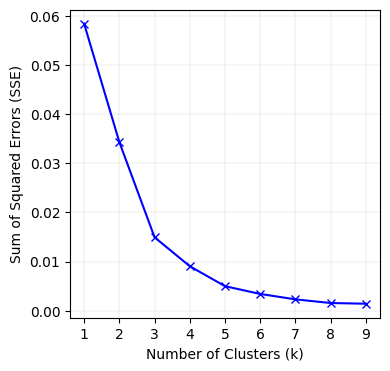

In [166]:
plt.figure(figsize=(4,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(K)
plt.grid(color='gray', linestyle='-', linewidth=0.1)
plt.show()

In [167]:
cluster_count = 4

kmeans = KMeans(n_clusters=cluster_count, verbose=False, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

labels = kmeans.fit_predict(X_embedded)

In [168]:
df_embedded = pd.DataFrame(X_embedded, columns=['pc_1', 'pc_2'])

Text(0, 0.5, 'pc_2')

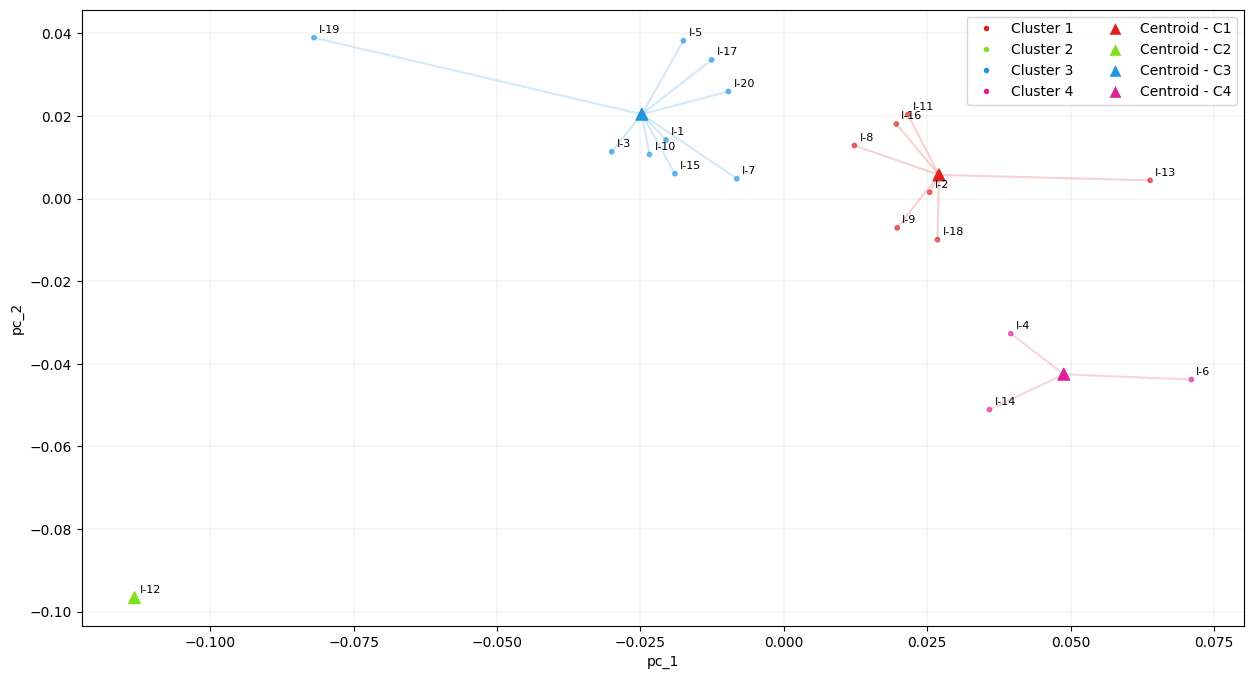

In [169]:
df_embedded['cluster'] = labels

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

# add to df
df_embedded['cen_x'] = df_embedded.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
df_embedded['cen_y'] = df_embedded.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#df2095']
df_embedded['c'] = df_embedded.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, figsize=(15,8))
# plot data
plt.scatter(df_embedded.pc_1, df_embedded.pc_2, c=df_embedded.c, alpha = 0.6, s=10)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

for idx, val in df_embedded.iterrows():
    x = [val.pc_1, val.cen_x,]
    y = [val.pc_2, val.cen_y]
    plt.plot(x, y, c=val.c, alpha=0.2)

# create a list of legend elemntes
# ## average line
legend_elements = []#[Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
            markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1),
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]

# site_names = industry_results_perc.columns
site_names = ['I-1', 'I-2', 'I-3', 'I-4', 'I-5', 'I-6', 'I-7', 'I-8', 'I-9', 'I-10', 'I-11', 'I-12', 'I-13', 'I-14', 'I-15', 'I-16', 'I-17', 'I-18', 'I-19', 'I-20']

# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, label=site_names, s=300)
for i, label in enumerate(site_names):
    plt.annotate(label, (X_embedded[:, 0][i], X_embedded[:, 1][i]), fontsize=8, xytext=(5, 5), textcoords="offset pixels")

# plt.show()

# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)
plt.grid(color='gray', linestyle='-', linewidth=0.1)
plt.legend(handles=legend_elements, loc='upper right', ncol=2)
# plt.title('Demand Clusters', fontsize=15)
plt.xlabel('pc_1')
plt.ylabel('pc_2')

## Correlation

In [170]:
industry_results_perc.transpose().corr()

,Automated Workflows and Efficiency,Collaboration and Integration,Cultural Change and Adoption,Customized and Tailored Solutions,Data Accessibility and Self-Service,Real-time Data and Decision Making,Standardization and Governance,Training and Empowerment
Automated Workflows and Efficiency,1.000000,0.107843,-0.393571,-0.140651,-0.480613,0.403976,-0.129675,-0.355786
Collaboration and Integration,0.107843,1.000000,-0.558069,0.392590,-0.349606,0.106276,0.135087,-0.401262
Cultural Change and Adoption,-0.393571,-0.558069,1.000000,-0.660408,0.323558,-0.245621,-0.182936,0.444855
Customized and Tailored Solutions,-0.140651,0.392590,-0.660408,1.000000,-0.214630,0.125488,-0.080095,-0.375121
Data Accessibility and Self-Service,-0.480613,-0.349606,0.323558,-0.214630,1.000000,-0.589886,-0.162339,0.085284
Real-time Data and Decision Making,0.403976,0.106276,-0.245621,0.125488,-0.589886,1.000000,-0.259235,-0.433536
Standardization and Governance,-0.129675,0.135087,-0.182936,-0.080095,-0.162339,-0.259235,1.000000,0.119597
Training and Empowerment,-0.355786,-0.401262,0.444855,-0.375121,0.085284,-0.433536,0.119597,1.000000


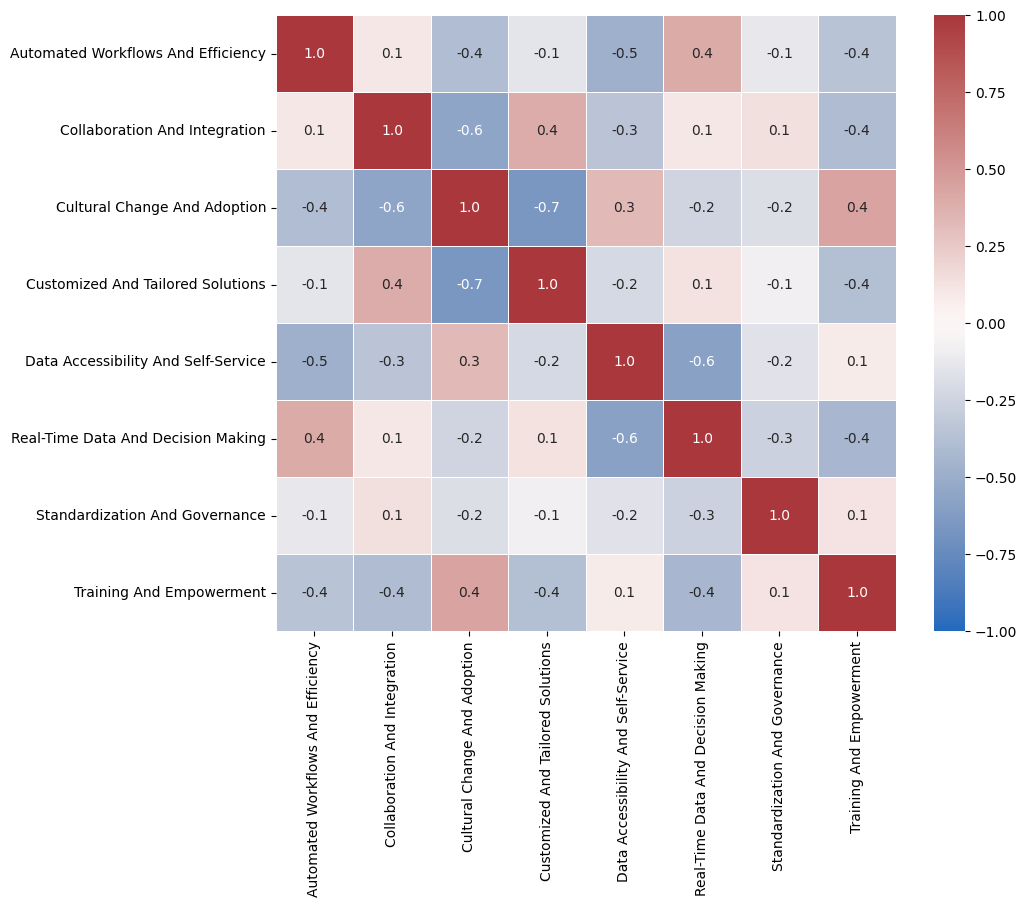

In [171]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(industry_results_perc.transpose().select_dtypes(include=['number', 'bool']).columns.values)]


# method ='pearson'
# method ='kendall'
# method ='spearman'

fig, ax = plt.subplots(figsize=(10,8))
_ = sns.heatmap(industry_results_perc.transpose().corr(method ='pearson'), annot=True, vmin=-1, vmax=1, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, linewidth=.5, fmt=".1f")

## Deep Insight

In [1]:
prompt_placeholder_deep = """
{story}
**Objective:** Extract key insights from the customer testimonial about this company's Business Intelligence (BI) adoption and implementation process.

**Guiding Questions:**
1. **Social Responsibility Support:** How does the BI platform assist in promoting social responsibility, including features or analyses related to community engagement, diversity and inclusion, and ethical business practices?
2. **Stakeholder Engagement:** What evidence is there of becoming a more attractive partner for clients/collaborators by being able to share insights or be transparent?

**Instructions to the Model:**
1. **Prioritize Accuracy:** Extract information directly from the text. Do not fabricate or "hallucinate" details.
2. **Handle Missing Information:** It's possible the story has nothing related to the questions. So, if a topic is not mentioned in the testimonial, indicate "Information not found" in the corresponding JSON field.

**Output:** Summarize the extracted information into JSON format with keys:
- `social_responsibility`
- `stakeholder_engagement`

"""

In [10]:
with open('/home/ashkan/Code/testimonial_llm_analysis/data/data_final.json') as f:
    stories = json.load(f)

In [11]:
data_deep = collect_data(stories, prompt_placeholder_deep, client)  # Step 1



Extracting: 100%|██████████| 2583/2583 [1:46:22<00:00,  2.47s/it]  


In [12]:
json_data_deep = convert_to_json(data_deep)         # Step 2


In [14]:
with open('results_deep.json', 'w') as f:
    json.dump(json_data_deep, f)  

In [ ]:
json_data_deep